In [212]:
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

In [213]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
label_encoder = LabelEncoder()
standard_scaler = StandardScaler()

In [214]:
def giniImpurity(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return np.sum(ps * (1 - ps))

In [215]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [216]:
def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

In [217]:
class DecisionTree(BaseEstimator):
  def __init__(self, min_num_samples_split=5, max_tree_depth=1):
    self.min_num_samples_split = min_num_samples_split
    self.max_tree_depth = max_tree_depth
    self.root = None

  def fit(self, X, y):
    self.num_features = X.shape[1]
    self.root = self.grow_tree(X, y)

  def grow_tree(self, X, y, depth=0):
    num_samples, num_features = X.shape
    num_labels = len(np.unique(y))

    # Stopping criteria
    if (depth >= self.max_tree_depth or num_labels == 1 or num_samples < self.min_num_samples_split):
      leaf_value = most_common_label(y)
      return Node(value=leaf_value)

    best_feature, best_threshold = self.get_best_split(X, y, num_features)

    # Grow the tree from the split
    left_idxs, right_idxs = self.split(X[:, best_feature], best_threshold)
    left = self.grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
    right = self.grow_tree(X[right_idxs, :], y[right_idxs], depth+1)

    return Node(best_feature, best_threshold, left, right)

  def get_best_split(self, X, y, num_features):
    best_gini_gain = -1
    split_index, split_threshold = None, None
    for feature_index in range(num_features):
      X_column = X[:, feature_index]
      thresholds = np.unique(X_column)
      for threshold in thresholds:
        gain = self.gini_gain(y, X_column, threshold)

        if gain > best_gini_gain:
          best_gini_gain = gain
          split_index = feature_index
          split_threshold = threshold

    return split_index, split_threshold

  def gini_gain(self, y, X_column, split_threshold):
    parent_impurity = giniImpurity(y)

    # generate split
    left_idxs, right_idxs = self.split(X_column, split_threshold)

    if len(left_idxs) == 0 or len(right_idxs) == 0:
        return 0

    # compute the weighted average for the children
    n = len(y)
    num_left, num_right = len(left_idxs), len(right_idxs)
    left_impurity, right_impurity = giniImpurity(y[left_idxs]), giniImpurity(y[right_idxs])
    child_impurity = (num_left / n) * left_impurity + (num_right / n) * right_impurity

    # gini gain is difference in loss before vs. after split
    gain = parent_impurity - child_impurity
    return gain

  def split(self, X_column, split_threshold):
    left_idxs = np.argwhere(X_column <= split_threshold).flatten()
    right_idxs = np.argwhere(X_column > split_threshold).flatten()
    return left_idxs, right_idxs

  def predict(self, X):
    return np.array([self.traverse_tree(x, self.root) for x in X])

  def traverse_tree(self, x, node):
    if node.is_leaf_node():
        return node.value

    if x[node.feature] <= node.threshold:
        return self.traverse_tree(x, node.left)
    return self.traverse_tree(x, node.right)

In [218]:
class AdaBooster(BaseEstimator):
    def __init__(self,
                 num_estimators=10,
                 min_num_samples_split=5):
        self.num_estimators = num_estimators
        self.min_num_samples_split = min_num_samples_split
        self.alphas = []
        self.trees = []

    def fit(self, X, y):
        weights = np.ones(X.shape[0]) / X.shape[0]
        print(f"Initial weights: {weights[:5]} and has length {len(weights)}")

        for _ in range(self.num_estimators):
            bootstrapped_indices = np.random.choice(X.shape[0], size=X.shape[0], p=weights)
            X_resampled = X[bootstrapped_indices]
            y_resampled = y[bootstrapped_indices]

            # Find unique elements and their counts
            unique_elements, counts = np.unique(bootstrapped_indices, return_counts=True)

            # Print duplicates and their counts
            for element, count in list(zip(unique_elements, counts))[:5]:
                if element < 5 and count > 1:  # Only print duplicates
                    print(f"Element: {element}, Count: {count}")

            tree = DecisionTree()
            tree.fit(X_resampled, y_resampled)
            self.trees.append(tree)

            predictions = tree.predict(X)
            error = np.sum(weights * (predictions != y)) / np.sum(weights)
            print(f"Error is: {error}")
            alpha = 0.5 * np.log((1 - error) / (error + 1e-10))
            print(f"Alpha is: {alpha}")
            self.alphas.append(alpha)

            # Update weights
            weights *= np.exp(-alpha * y * predictions)
            weights /= np.sum(weights)
            print(f"New weights: {weights[:5]} and has length {len(weights)}")

    def predict(self, X):
        print(self.alphas)
        predictions = np.zeros(X.shape[0])
        for tree, alpha in zip(self.trees, self.alphas):
            predictions += alpha * tree.predict(X)
        return (predictions > 0.5).astype(int)

In [219]:
# Mount Google drive and copy kaggle.json to local disk

from google.colab import drive
drive.mount('mount')

!cp mount/MyDrive/kaggle.json .

Drive already mounted at mount; to attempt to forcibly remount, call drive.mount("mount", force_remount=True).


In [220]:
!KAGGLE_CONFIG_DIR=$(pwd) kaggle datasets download rabieelkharoua/students-performance-dataset

Dataset URL: https://www.kaggle.com/datasets/rabieelkharoua/students-performance-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
students-performance-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [221]:
!unzip -o students-performance-dataset.zip -d students-performance-dataset

Archive:  students-performance-dataset.zip
  inflating: students-performance-dataset/Student_performance_data _.csv  


In [222]:
student_performance_df_orig = pd.read_csv('students-performance-dataset/Student_performance_data _.csv')

In [223]:
student_performance_df = student_performance_df_orig.drop(['StudentID', 'GradeClass', 'GPA'], axis=1)
student_performance_df = pd.DataFrame(standard_scaler.fit_transform(student_performance_df), columns=student_performance_df.columns)
student_performance_df

,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering
0,0.472919,0.978492,-0.853391,0.253711,1.780336,-0.890822,1.522371,-0.108744,-0.788476,-0.660132,2.019544,-0.431866
1,1.362944,-1.021981,-0.853391,-0.746087,0.997376,-1.717694,-0.656870,-0.999551,-0.788476,-0.660132,-0.495161,-0.431866
2,-1.307132,-1.021981,1.091641,1.253509,-0.984045,1.353542,-0.656870,-0.108744,-0.788476,-0.660132,-0.495161,-0.431866
3,0.472919,0.978492,-0.853391,1.253509,0.045445,-0.063951,-0.656870,0.782063,1.268269,-0.660132,-0.495161,-0.431866
4,0.472919,0.978492,-0.853391,0.253711,-0.902311,0.290422,1.522371,0.782063,-0.788476,-0.660132,-0.495161,-0.431866
...,...,...,...,...,...,...,...,...,...,...,...,...
2387,1.362944,0.978492,-0.853391,1.253509,0.160762,-1.481445,-0.656870,1.672869,1.268269,-0.660132,-0.495161,-0.431866
2388,0.472919,-1.021981,-0.853391,-0.746087,-0.387285,-1.245196,1.522371,1.672869,-0.788476,1.514848,-0.495161,-0.431866
2389,-0.417106,0.978492,-0.853391,0.253711,-0.524895,0.644796,-0.656870,-0.108744,-0.788476,-0.660132,-0.495161,2.315535
2390,-0.417106,0.978492,0.119125,-1.745885,0.467950,0.290422,-0.656870,-0.108744,-0.788476,1.514848,2.019544,-0.431866


In [224]:
student_performance_target = np.array(student_performance_df_orig['GradeClass'].map(lambda gradeclass: 0 if gradeclass <= 3.0 else 1), dtype=np.int8)
student_performance_target

array([0, 0, 1, ..., 0, 0, 0], dtype=int8)

In [225]:
from sklearn.model_selection import cross_val_score

ada_booster = AdaBooster(num_estimators=3)

cross_val_score(ada_booster, student_performance_df.values, student_performance_target, cv=2, scoring='accuracy')

Initial weights: [0.00083612 0.00083612 0.00083612 0.00083612 0.00083612] and has length 1196
Element: 2, Count: 4
Element: 3, Count: 2
Element: 4, Count: 2
Error is: 0.1697324414715719
Alpha is: 0.7937623422071114
New weights: [0.00110755 0.00050077 0.00050077 0.00110755 0.00050077] and has length 1196
Element: 0, Count: 2
Error is: 0.18228093028928055
Alpha is: 0.7504848857473453
New weights: [0.0012662 0.0002703 0.0002703 0.0012662 0.0005725] and has length 1196
Element: 4, Count: 2
Error is: 0.22226538026577283
Alpha is: 0.6262566426266637
New weights: [0.00135416 0.00015454 0.00015454 0.00135416 0.00032731] and has length 1196
[0.7937623422071114, 0.7504848857473453, 0.6262566426266637]
Initial weights: [0.00083612 0.00083612 0.00083612 0.00083612 0.00083612] and has length 1196
Element: 1, Count: 2
Element: 3, Count: 2
Element: 4, Count: 2
Error is: 0.10618729096989964
Alpha is: 1.065145911812361
New weights: [0.00117739 0.00117739 0.00040582 0.00117739 0.00040582] and has length

array([0.88795987, 0.83444816])

In [226]:
from sklearn.model_selection import cross_val_score

ada_booster = AdaBooster(num_estimators=7)

cross_val_score(ada_booster, student_performance_df.values, student_performance_target, cv=2, scoring='accuracy')

Initial weights: [0.00083612 0.00083612 0.00083612 0.00083612 0.00083612] and has length 1196
Element: 2, Count: 2
Error is: 0.1697324414715719
Alpha is: 0.7937623422071114
New weights: [0.00110755 0.00050077 0.00050077 0.00110755 0.00050077] and has length 1196
Error is: 0.18228093028928055
Alpha is: 0.7504848857473453
New weights: [0.0012662 0.0002703 0.0002703 0.0012662 0.0005725] and has length 1196
Element: 0, Count: 4
Error is: 0.2014621755685228
Alpha is: 0.6885903429638128
New weights: [0.00134203 0.0001439  0.0001439  0.00134203 0.00060678] and has length 1196
Error is: 0.18002212561950243
Alpha is: 0.7580987967157353
New weights: [0.00134203 0.0001439  0.0001439  0.00134203 0.00060678] and has length 1196
Element: 0, Count: 3
Element: 3, Count: 3
Error is: 0.1800221256195024
Alpha is: 0.7580987967157354
New weights: [0.00134203 0.0001439  0.0001439  0.00134203 0.00060678] and has length 1196
Error is: 0.18002212561950243
Alpha is: 0.7580987967157353
New weights: [0.00134203 0

array([0.88795987, 0.81521739])

In [227]:
from sklearn.model_selection import cross_val_score

ada_booster = AdaBooster(num_estimators=11)

cross_val_score(ada_booster, student_performance_df.values, student_performance_target, cv=2, scoring='accuracy')

Initial weights: [0.00083612 0.00083612 0.00083612 0.00083612 0.00083612] and has length 1196
Error is: 0.16555183946488292
Alpha is: 0.8087431225064442
New weights: [0.00107166 0.00047734 0.00047734 0.00107166 0.00107166] and has length 1196
Element: 0, Count: 3
Error is: 0.21754787950095017
Alpha is: 0.6400068851414746
New weights: [0.00124302 0.00029194 0.00029194 0.00124302 0.00065543] and has length 1196
Element: 3, Count: 5
Error is: 0.24051262470634455
Alpha is: 0.5749355586704225
New weights: [0.00124302 0.00029194 0.00029194 0.00124302 0.00065543] and has length 1196
Element: 3, Count: 3
Error is: 0.22202742123902597
Alpha is: 0.6269451919795981
New weights: [0.00133739 0.0001678  0.0001678  0.00133739 0.00037673] and has length 1196
Element: 3, Count: 2
Error is: 0.18285466484322754
Alpha is: 0.7485626555868178
New weights: [0.00133739 0.0001678  0.0001678  0.00133739 0.00037673] and has length 1196
Element: 0, Count: 3
Error is: 0.18285466484322754
Alpha is: 0.74856265558681

array([0.88795987, 0.83026756])

In [228]:
from sklearn.model_selection import cross_val_predict

student_performance_predicted_target = cross_val_predict(ada_booster, student_performance_df.values, student_performance_target, cv=2)

Initial weights: [0.00083612 0.00083612 0.00083612 0.00083612 0.00083612] and has length 1196
Element: 0, Count: 2
Error is: 0.1697324414715719
Alpha is: 0.7937623422071114
New weights: [0.00110755 0.00050077 0.00050077 0.00110755 0.00050077] and has length 1196
Element: 1, Count: 2
Error is: 0.18228093028928055
Alpha is: 0.7504848857473453
New weights: [0.0012662 0.0002703 0.0002703 0.0012662 0.0005725] and has length 1196
Error is: 0.20429369881871567
Alpha is: 0.6798357451713397
New weights: [0.00134645 0.00014564 0.00014564 0.00134645 0.00060878] and has length 1196
Element: 0, Count: 2
Element: 4, Count: 2
Error is: 0.1773201925321482
Alpha is: 0.7673049867106765
New weights: [0.00134645 0.00014564 0.00014564 0.00134645 0.00060878] and has length 1196
Error is: 0.1773201925321482
Alpha is: 0.7673049867106765
New weights: [0.00134645 0.00014564 0.00014564 0.00134645 0.00060878] and has length 1196
Element: 0, Count: 2
Element: 3, Count: 3
Error is: 0.1773201925321482
Alpha is: 0.76

In [229]:
student_performance_predicted_target

array([0, 0, 1, ..., 1, 1, 1])

In [230]:
from sklearn.metrics import confusion_matrix

In [231]:
confusion_matrix(student_performance_target, student_performance_predicted_target)

array([[ 897,  284],
       [  71, 1140]])

In [232]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_score(student_performance_target, student_performance_predicted_target, average='weighted')

0.8628166401314191

In [233]:
recall_score(student_performance_target, student_performance_predicted_target, average='weighted')

0.8515886287625418

In [234]:
f1_score(student_performance_target, student_performance_predicted_target, average='weighted')

0.8502320780940116

In [235]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(student_performance_target, student_performance_predicted_target)

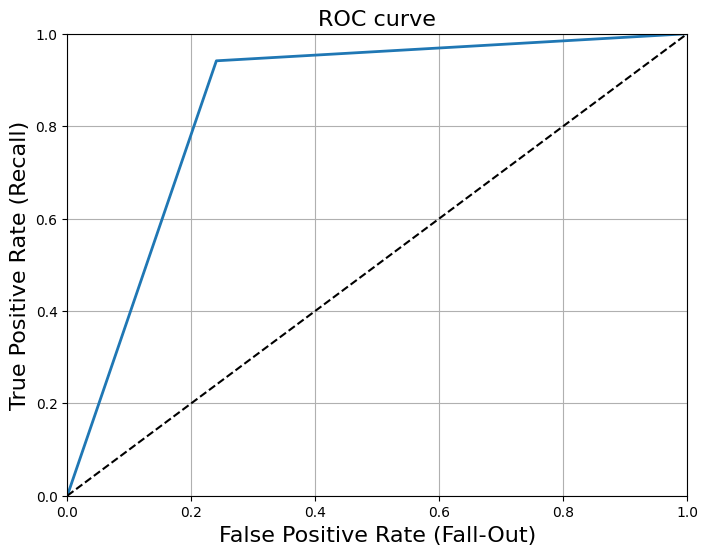

In [236]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.title("ROC curve", fontsize=16)
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [237]:
from sklearn.metrics import roc_auc_score

roc_auc_score(student_performance_target, student_performance_predicted_target)

0.8504482967659565